# WSA TensorFlow Demo Code

### Imports
* Don't forget to run `pip install tensorflow` in your terminal first!

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

## Example 1: Predicting Points Scored with GameLog Data

### Data Preprocessing

In [6]:
df = pd.read_csv('Michigan_GameLogs_F24.csv').drop(columns=['id'])
df.rename(columns = {
    'home_away' : 'location',
    'points_scored' : 'pts_scored',
    'points_against' : 'pts_against',
    'pass_td' : 'pass_tds',
    'pass_1st_down' : 'pass_first_downs',
    'rush_td' : 'rush_tds',
    'rush_1st_down' : 'rush_first_downs'
}, inplace = True)

In [7]:
# Holding out most recent games for testing
df_parsed = df[['pts_scored', 'pts_against', 'pass_cmp', 'pass_att', 'pass_pct', 'pass_yrds', 'pass_tds', 'pass_first_downs',
                'rush_att', 'rush_yrds', 'rush_tds', 'rush_first_downs', 'total_offense', 'fumbles', 'ints']][:-3]
df_parsed.tail()

,pts_scored,pts_against,pass_cmp,pass_att,pass_pct,pass_yrds,pass_tds,pass_first_downs,rush_att,rush_yrds,rush_tds,rush_first_downs,total_offense,fumbles,ints
167,28,18,13,18,72.2,134,1,6,44,301,3,14,435,0,3
168,27,24,7,12,58.3,32,0,0,46,290,3,12,322,2,0
169,27,24,10,18,55.6,86,1,5,43,155,2,9,241,0,1
170,17,27,13,25,52.0,113,1,7,37,174,1,9,287,1,1
171,7,21,20,32,62.5,208,0,8,38,114,1,10,322,2,1


### Splitting our Data for Training and Validation

In [9]:
# Selecting 75% of data for training data
# Setting the random state value fixes the split for reproducibility
# The other 25% will be used for validation

train_df = df_parsed.sample(frac=0.75, random_state=4)
validation_df = df_parsed.drop(train_df.index)

In [10]:
# Normalizing data to be between 0 and 1
max_val = train_df.max(axis = 0)
min_val = train_df.min(axis = 0)

train_df_norm = (train_df-min_val)/(max_val-min_val)
validation_df_norm = (validation_df-min_val)/(max_val-min_val)

train_df_norm.head()

,pts_scored,pts_against,pass_cmp,pass_att,pass_pct,pass_yrds,pass_tds,pass_first_downs,rush_att,rush_yrds,rush_tds,rush_first_downs,total_offense,fumbles,ints
93,0.717949,0.161290,0.423077,0.575,0.457565,0.398034,0.333333,0.368421,0.627907,0.623596,0.444444,0.60,0.663347,0.000000,0.2
135,0.141026,0.548387,0.423077,0.700,0.308118,0.474201,0.166667,0.368421,0.209302,0.260300,0.000000,0.30,0.338645,0.333333,0.4
48,0.128205,0.145161,0.153846,0.400,0.230627,0.159705,0.000000,0.263158,0.395349,0.365169,0.111111,0.30,0.195219,0.333333,0.4
147,0.576923,0.370968,0.230769,0.425,0.345018,0.574939,0.500000,0.210526,0.395349,0.561798,0.333333,0.35,0.741036,0.000000,0.0
14,0.397436,0.403226,0.269231,0.425,0.418819,0.402948,0.333333,0.526316,0.302326,0.490637,0.222222,0.35,0.525896,0.000000,0.2


### Separate our Data into Labels and Targets

In [12]:
# Our model is looking for targets and labels so we need to separate our data into such categories
# In this case, we want points scored to be the target (output) and rest of columns are labels (inputs for model)

X_train = train_df_norm.drop('pts_scored', axis=1)
X_val = validation_df_norm.drop('pts_scored', axis=1)

y_train = train_df_norm['pts_scored']
y_val = validation_df_norm['pts_scored']

In [13]:
# Format the features/inputs as an argument for model
input_shape = (X_train.shape[1],)
input_shape

(14,)

`input_shape` equal to `14` denotes that we will pass 14 features as an input to the first layer of our neural network.

### Building our Model using Keras
* To build our model, we are going to use the built-in Keras library within TensorFlow
    * `Sequential` API suitable for multilayered neural networks
* Three layer network
    * One input layer
    * One hidden layer
    * One output layer
* The input and hidden layers will have 64 units/node
    * Our layers will be fully connected, or `Dense` layers in Keras
* We will use a common activation function called the Rectified Linear Unit (ReLU) in our input and hidden layers
    * Activation functions are used to introduce non-linearity to NNs 
    * ReLU: $f(x) = \text{max}(0,x)$

In [16]:
model = keras.Sequential([
    keras.layers.Input(shape = input_shape, name = 'input'),  # specifying input shape here
    keras.layers.Dense(units = 64, activation = 'relu', name = 'input_layer'),
    keras.layers.Dense(units = 64, activation = 'relu', name = 'hidden_layer'),
    keras.layers.Dense(units = 1, name = 'output_layer')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)             │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (Dense)            │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,185 (20.25 KB)

 Trainable params: 5,185 (20.25 KB)

 Non-trainable params: 0 (0.00 B)

We will use the [Adam](https://arxiv.org/abs/1412.6980) optimizer, and **MAE** (mean absolute error) as our model's loss function.

In [18]:
# Compile the model with our chosen optimizer and loss function
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mae')

### Training our Model in Batches
* Our model is trained by feeding it batches through multiple 'epochs', or iterations
    * This is helpful for digesting large amounts of data
    * This specific data set is small but others are significantly larger
    * Batching refers to breaking our total training data into smaller groups and feeding them into the model

In [20]:
# This may take a while depending on the batch size, training dataset size, and number of epochs
losses = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.4605 - val_loss: 0.2583
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2052 - val_loss: 0.0942
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1112 - val_loss: 0.1433
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1429 - val_loss: 0.0952
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0986 - val_loss: 0.0902
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0942 - val_loss: 0.1109
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0972 - val_loss: 0.0922
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0809 - val_loss: 0.0771
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0812 - val_loss: 0.0840
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0820 - val_loss: 0.0712
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0709 - val_loss: 0.0720
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0663 - val_loss: 0.0702
E

### Training vs Validation Loss

We can analyze our training vs validation loss to see if our model is overfitting the data. To do this, we create a DataFrame and plot all of the loss values across epochs.
* The `.history` property stores the training loss and validation in each epoch for the fitted model

<Axes: title={'center': 'Model Training and Validation Loss'}, xlabel='epoch', ylabel='Mean Absolute Error'>

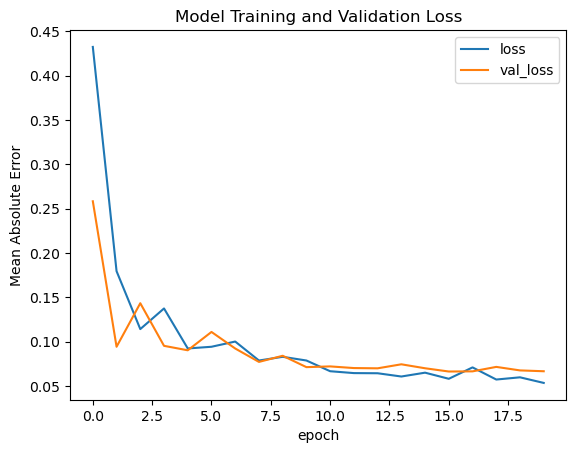

In [31]:
loss_df = pd.DataFrame(losses.history)
loss_df.loc[:, ['loss', 'val_loss']].plot(xlabel='epoch', ylabel='Mean Absolute Error', title='Model Training and Validation Loss')

If validation loss stagnates or increases while training loss continues to decrease, then the model will likely overfit our testing data. We should not train our model for more epochs than is necessary for minimizing validation loss.

### Compare Predictions to Actual Results


In [33]:
# Passing the last 3 rows of our data (kept out) to make predictions on
# Labels normalized first
labels = df[['pts_scored', 'pts_against', 'pass_cmp', 'pass_att', 'pass_pct', 'pass_yrds', 'pass_tds', 'pass_first_downs',
                'rush_att', 'rush_yrds', 'rush_tds', 'rush_first_downs', 'total_offense', 'fumbles', 'ints']][-3:]
labels_norm = ((labels-min_val)/(max_val-min_val)).drop('pts_scored', axis=1)

model.predict(labels_norm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


array([[0.33707678],
       [0.26610434],
       [0.15385644]], dtype=float32)

In [35]:
# We can compare the predicted values to our true values by renormalizing the targets
model.predict(labels_norm) * (train_df['pts_scored'].max()-train_df['pts_scored'].min()) + (train_df['pts_scored'].min())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array([[26.291988],
       [20.756138],
       [12.000802]], dtype=float32)

In [37]:
df[['date', 'opponent', 'pts_scored']][-3:]

,date,opponent,pts_scored
172,2024-10-26,Michigan State,24
173,2024-11-02,Oregon,17
174,2024-11-09,Indiana,15
